# Omniglot Character Set Classification Using Prototypical Network 

In [1]:
import os
import glob
from PIL import Image

import numpy as np
!pip install tensorflow==1.14

import tensorflow as tf
%tensorflow_version 1.x

     |████████████████████████████████| 109.2MB 36kB/s 
     |████████████████████████████████| 3.2MB 53.8MB/s 
     |████████████████████████████████| 491kB 56.0MB/s 
  Found existing installation: tensorboard 2.1.0
    Uninstalling tensorboard-2.1.0:
      Successfully uninstalled tensorboard-2.1.0
  Found existing installation: tensorflow-estimator 1.15.0
    Uninstalling tensorflow-estimator-1.15.0:
      Successfully uninstalled tensorflow-estimator-1.15.0
  Found existing installation: tensorflow 2.1.0
    Uninstalling tensorflow-2.1.0:
      Successfully uninstalled tensorflow-2.1.0
TensorFlow is already loaded. Please restart the runtime to change versions.


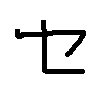

In [4]:
# view sample images 
Image.open('/content/drive/My Drive/Emerging Technologies/Assignment 4/data/images/Japanese_(katakana)/character13/0608_01.png')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


the same alphabet in different variation

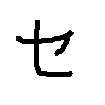

In [5]:
# view sample images 

Image.open('/content/drive/My Drive/Emerging Technologies/Assignment 4/data/images/Japanese_(katakana)/character13/0608_13.png')

In [6]:
imagename = '/content/drive/My Drive/Emerging Technologies/Assignment 4/data/images/Sanskrit/character13/0863_13.png'
alphabet, character, rotation = 'Sanskrit/character13/rot000'.split('/')
rotation = float(rotation[3:])

In [7]:
# convert the images in vector format 

np.array(Image.open(imagename).rotate(rotation).resize((28, 28)), np.float32,copy=True)

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1

In [8]:
rootdir = '/content/drive/My Drive/Emerging Technologies/Assignment 4/data/'

We have the splitting details in the /data/omniglot/splits/train.txt file which has the language name, character number, rotation information and images in /data/omniglot/data/ directory.

In [9]:
# split the trainind data details 
trainsplitpath = os.path.join(rootdir, 'splits', 'train.txt')

with open(trainsplitpath, 'r') as train_split:
    trainclasses = [line.rstrip() for line in train_split.readlines()]

In [10]:
# store the number of classes 
noofclasses = len(trainclasses)

Now we set the number of examples to 20, as we have 20 example per class in our dataset, and also we set image width and height to 28 x 28:

In [11]:
# specify the number of examples, width and height 
numexamples = 20

imgwidth = 28

imgheight = 28
channels = 1

Next, we initialize our training dataset with a shape as a number of classes, number of examples, image height and image width:

In [12]:
# load the training dataset 
traindataset = np.zeros([noofclasses, numexamples, imgheight, imgwidth], dtype=np.float32)

Now, we read all the images, convert it to numpy array and store it our traindataset array with their label and values, that is,  traindataset = [label, values]:

In [13]:
# read the images, convert into array and store with label and values 
for label, name in enumerate(trainclasses):
    alphabet, character, rotation = name.split('/')
    rotation = float(rotation[3:])
    img_dir = os.path.join(rootdir, 'data', alphabet, character)
    img_files = sorted(glob.glob(os.path.join(img_dir, '*.png')))
  
    
    for index, img_file in enumerate(img_files):
        values = 1. - np.array(Image.open(img_file).rotate(rotation).resize((imgwidth, imgheight)), np.float32, copy=False)
        traindataset[label, index] = values

In [14]:
traindataset.shape

(4112, 20, 28, 28)

Now that we have loaded our training data, we need to create embeddings for them. We generate the embeddings using a convolution operation as our inputs are images. So, we define a convolutional block with 64 filters with batch normalization and ReLU as the activation function. Followed by we perform max pooling operation:

In [15]:
# define convolution block 
def convolutionblock(inputs, out_channels, name='conv'):

    conv = tf.layers.conv2d(inputs, out_channels, kernel_size=3, padding='SAME')
    conv = tf.contrib.layers.batch_norm(conv, updates_collections=None, decay=0.99, scale=True, center=True)
    conv = tf.nn.relu(conv)
    conv = tf.contrib.layers.max_pool2d(conv, 2)
    
    return conv

Now, we define our embedding function which gives us the embedding comprising of four convolutional blocks:

In [16]:
# generate embeddings using convolution operation 
def getembeddings(support_set, h_dim, z_dim, reuse=False):

        net = convolutionblock(support_set, h_dim)
        net = convolutionblock(net, h_dim)
        net = convolutionblock(net, h_dim) 
        net = convolutionblock(net, z_dim) 
        net = tf.contrib.layers.flatten(net)
        
        return net

Remember, we don't use our whole dataset for training, since we are one shot learning, we sample some data points from each class as a support set and train the network using the support set in an episodic fashion. 


Now we define some of the important variables, we consider a 60-way 5-shot learning scenario:

In [17]:
# classes 
numway = 60  

# examples per class 
num_shot = 5  

# query points 
num_query = 5 

# examples 
numexamples = 20

h_dim = 64

z_dim = 64

Next, we initialize placeholders for our support set and query set:

In [18]:
# define support and query set 
support_set = tf.placeholder(tf.float32, [None, None, imgheight, imgwidth, channels])
query_set = tf.placeholder(tf.float32, [None, None, imgheight, imgwidth, channels])

In [19]:
%tensorflow_version 1.x

TensorFlow is already loaded. Please restart the runtime to change versions.


And we store the shape of our support set and query set in support_set_shape and query_set_shape respectively:

In [20]:
support_set_shape = tf.shape(support_set)
query_set_shape = tf.shape(query_set)

Get the number of classes and number of data points in the support set and number of data points in the query set for initializing our support and query sets:

In [21]:
# get number of classes and data points 
num_classes, num_support_points = support_set_shape[0], support_set_shape[1]

In [22]:
num_query_points = query_set_shape[1]

Next, we define the placeholder for our label:

In [23]:
y = tf.placeholder(tf.int64, [None, None])

# one hot encoding 
yonehot = tf.one_hot(y, depth=num_classes)

Now, we generate the embeddings for our support set using our embedding function:

In [24]:
# generate embeddings 

supportsetembeddings = getembeddings(tf.reshape(support_set, [num_classes * num_support_points, imgheight, imgwidth, channels]), h_dim, z_dim)

W1031 14:15:00.131005 140273433495424 deprecation.py:323] From <ipython-input-15-4ba6064d20c1>:3: conv2d (from tensorflow.python.layers.convolutional) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
W1031 14:15:00.137475 140273433495424 deprecation.py:506] From /usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling __init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1031 14:15:01.364614 140273433495424 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops

We compute the prototype of each class which is the mean vector of the support set embeddings of the class:

In [25]:
# compute prototpye of each class 
embeddingdimension = tf.shape(supportsetembeddings)[-1]

classprototype = tf.reduce_mean(tf.reshape(supportsetembeddings, [num_classes, num_support_points, embeddingdimension]), axis=1)

Next, we use our same embedding function for getting embeddings of the query set:

In [26]:
# query set embeddings 
querysetembeddings = getembeddings(tf.reshape(query_set, [num_classes * num_query_points, imgheight, imgwidth, channels]), h_dim, z_dim, reuse=True)

Now that, we have the class prototype and query set embeddings, we define a distance function which gives us the distance between the class prototypes and query set embeddings:

In [27]:
# define euclidean distance 
def euclideandistance(a, b):

    N, D = tf.shape(a)[0], tf.shape(a)[1]
    M = tf.shape(b)[0]
    a = tf.tile(tf.expand_dims(a, axis=1), (1, M, 1))
    b = tf.tile(tf.expand_dims(b, axis=0), (N, 1, 1))
    return tf.reduce_mean(tf.square(a - b), axis=2)


Calculate the distance between the class prototype and query set embeddings:

In [28]:
distance = euclideandistance(classprototype,querysetembeddings)

Next, we get the probability for each class as a softmax to the distance:

In [29]:
# probability of each class 
predicted_probability = tf.reshape(tf.nn.log_softmax(-distance), [num_classes, num_query_points, -1])

Compute the loss

In [30]:
# compute loss 
loss = -tf.reduce_mean(tf.reshape(tf.reduce_sum(tf.multiply(yonehot, predicted_probability), axis=-1), [-1]))

Calculate accuracy

In [31]:
# accuracy 
accuracy = tf.reduce_mean(tf.to_float(tf.equal(tf.argmax(predicted_probability, axis=-1), y)))

W1031 14:15:10.746479 140273433495424 deprecation.py:323] From <ipython-input-31-8b342a457945>:1: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.


We use Adam optimizer for minimizing the loss:



In [32]:
# use Adam optimizer to reduce loss
train = tf.train.AdamOptimizer().minimize(loss)

Now, we start our tensorflow session and train the model,

In [33]:
# start tensorflow session 
sess = tf.InteractiveSession()
init = tf.global_variables_initializer()
sess.run(init)

In [34]:
# defien epochs and episodes 
numepochs = 20
numepisodes = 100

In [35]:
for epoch in range(numepochs):
    
    for episode in range(numepisodes):
        
        # select 60 classes
        episodicclasses = np.random.permutation(noofclasses)[:numway]
        
        support = np.zeros([numway, num_shot, imgheight, imgwidth], dtype=np.float32)
        
        query = np.zeros([numway, num_query, imgheight, imgwidth], dtype=np.float32)
        
        
        for index, class_ in enumerate(episodicclasses):
            selected = np.random.permutation(numexamples)[:num_shot + num_query]
            support[index] = traindataset[class_, selected[:num_shot]]
            
            # 5 querypoints per classs
            query[index] = traindataset[class_, selected[num_shot:]]
            
        support = np.expand_dims(support, axis=-1)
        query = np.expand_dims(query, axis=-1)
        labels = np.tile(np.arange(numway)[:, np.newaxis], (1, num_query)).astype(np.uint8)
        _, loss_, accuracy_ = sess.run([train, loss, accuracy], feed_dict={support_set: support, query_set: query, y:labels})
        
        if (episode+1) % 10 == 0:
            print('Epoch {} : Episode {} : Loss: {}, Accuracy: {}'.format(epoch+1, episode+1, loss_, accuracy_))

Epoch 1 : Episode 10 : Loss: 5.70378160477, Accuracy: 0.0166666675359
Epoch 1 : Episode 20 : Loss: 5.70378160477, Accuracy: 0.0166666675359
Epoch 1 : Episode 30 : Loss: 5.70378160477, Accuracy: 0.0166666675359
Epoch 1 : Episode 40 : Loss: 5.70378160477, Accuracy: 0.0166666675359
Epoch 1 : Episode 50 : Loss: 5.70378160477, Accuracy: 0.0166666675359
Epoch 1 : Episode 60 : Loss: 5.70378160477, Accuracy: 0.0166666675359
Epoch 1 : Episode 70 : Loss: 5.70378160477, Accuracy: 0.0166666675359
Epoch 1 : Episode 80 : Loss: 5.70378160477, Accuracy: 0.0166666675359
Epoch 1 : Episode 90 : Loss: 5.70378160477, Accuracy: 0.0166666675359
Epoch 1 : Episode 100 : Loss: 5.70378160477, Accuracy: 0.0166666675359
Epoch 2 : Episode 10 : Loss: 5.70378160477, Accuracy: 0.0166666675359
Epoch 2 : Episode 20 : Loss: 5.70378160477, Accuracy: 0.0166666675359
Epoch 2 : Episode 30 : Loss: 5.70378160477, Accuracy: 0.0166666675359
Epoch 2 : Episode 40 : Loss: 5.70378160477, Accuracy: 0.0166666675359
Epoch 2 : Episode 5